In [8]:
cd drive/MyDrive/Colab\ Notebooks/NLP_twitter

/content/drive/MyDrive/Colab Notebooks/NLP_twitter


In [2]:
ls

data/  model_no_feat_engineering.ipynb  spacy_models/


In [4]:
!pip install emot

     |████████████████████████████████| 61 kB 9.6 kB/s 


Install Polish SpaCy

In [18]:
!pip install -U pip setuptools wheel
!pip install -U 'spacy[cuda111]'
!python -m spacy download pl_core_news_sm

     |████████████████████████████████| 2.1 MB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 56.3 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.3/653.3 KB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.1/457.1 KB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
 

In [109]:
import re
import os
import string
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

import spacy
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import tensorflow as tf

from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2, l1_l2


# Models
from sklearn.naive_bayes import BernoulliNB

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding

# Eval
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

# Data Preprocessing

Filter duplicate values

Steps for data preprocessing:

1. Lowering the text
2. Removing `newline (\n)` characters
3. Removing URLs
4. Removing numbers
5.  

## Constants

According to the EDA, 60% of the training data occurred only once. Thus, `num_words=9000` for the Tokenizer should be enough

We can also use padding as the max length of a tweet is `280` characters

In [62]:
class Labels(Enum):
    NON_HARMFUL = 0
    HARMFUL = 1


NUM_WORDS = 9_000
MAX_TWEET_LENGTH = 280
OOV_TOKEN = '<OOV>'

## Loading data

In [10]:
DATA_DIR = 'data/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train/')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test/')

MAX_TWEET_LENGTH = 280

In [11]:
!ls

data  model_no_feat_engineering.ipynb  spacy_models


In [12]:
os.listdir(TRAIN_DATA_DIR)

['training_set_clean_only_text.txt', 'training_set_clean_only_tags.txt']

In [13]:
TRAIN_DATA = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[0])
TRAIN_LABELS = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[1])

In [14]:
data_df = pd.read_csv(TRAIN_DATA, sep='\n', names=['text'])
labels_df = pd.read_csv(TRAIN_LABELS, sep='\n', names=['label'])

data_df.shape, labels_df.shape

((10041, 1), (10041, 1))

In [15]:
df = pd.concat([data_df, labels_df], axis=1)
df.head()

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


### Removing duplicates

In [16]:
df_clean_1 = df.filter(items=list(df['text'].drop_duplicates().index), axis=0).reset_index()
df_clean_1.shape

(10027, 3)

### Drop SPAM tweets

In [17]:
"""
8069,איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh
8070,rt @anonymized_account איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh
"""

'\n8069,איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh\n8070,rt @anonymized_account איזה רעיון של הנשיא פולני @anonymized_account מצוין :-)   sxlbtcpgh\n'

In [18]:
df_clean_1 = df_clean_1.drop([8069, 8070], axis=0)
df_clean_1.tail()

,index,text,label
10022,10036,@anonymized_account Ty zagrasz? Nie wiedziałem 😉,0
10023,10037,@anonymized_account @anonymized_account A VAR ...,0
10024,10038,@anonymized_account @anonymized_account Szanow...,0
10025,10039,@anonymized_account @anonymized_account @anony...,0
10026,10040,@anonymized_account A wróżbita Maciej mówi że ...,0


## Pipeline

In [58]:
from math import trunc
class LowerText:
  """Lowers text"""
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self
  
  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
     print('lower')
     return [value.lower() for value in X]


class FilterNewline:
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('newline')
    return [value.replace('\\n', ' ').replace('\\r', ' ') for value in X]


class FilterURL:
  def __init__(self, pattern):
    self.pattern = pattern

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('url')
    return [re.sub(self.pattern, ' ', value) for value in X]

  
class FilterNumbers:
  def __init__(self, pattern):
    self.pattern = pattern

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('numbers')
    return [re.sub(self.pattern, '', value) for value in X]


class EmojiTransformer:
  """Transforms emojis to words"""
  def __init__(self, UNICODE_EMOJI):
    self.UNICODE_EMOJI = UNICODE_EMOJI

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('emoji')
    for i, value in enumerate(X):
      for emot in self.UNICODE_EMOJI:
          value = value.replace(emot, "_".join([f'{self.UNICODE_EMOJI[emot]} '.replace(",","").replace(":","")]))
          X[i] = value
    return X


class FilterASCII:
  def __init__(self, pattern):
    self.pattern = pattern

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('ascii')
    return [re.sub(self.pattern, '', value) for value in X]


class FilterPunctuations:
  def __init__(self, punctuations):
    self.translator = str.maketrans('', '', punctuations)

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('punctuations')
    return [value.translate(self.translator) for value in X]


class LemmatizerPL:
  def __init__(self):
    self.lemma_model = spacy.load('pl_core_news_sm')
  
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('lemma')
    for i, value in enumerate(X):
      doc = self.lemma_model(value)
      X[i] = ' '.join([token.lemma_ for token in doc])
    return X


class Tokenizer_pipeline:
  def __init__(self, num_words, oov_token):
    self.num_words = num_words
    self.oov_token = oov_token
    self.tokenizer = Tokenizer(num_words=self.num_words,
                              oov_token=self.oov_token)

  def fit(self, X, y=None):
    self.tokenizer.fit_on_texts(X)

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('tokenizer')
    return self.tokenizer.texts_to_sequences(X)


class Padding:
  def __init__(self, maxlen, padding='post', truncating='post'):
    self.maxlen = maxlen
    self.padding = padding
    self.truncating = truncating

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('padding')
    return pad_sequences(X, padding=self.padding, truncating=self.truncating, maxlen=self.maxlen)

In [59]:
url_pattern = r'((www.[^s]+)|(https?://[^s]+))'
number_pattern = r'[0-9]+'
ascii_pattern = r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]'

punctuations = string.punctuation

In [60]:
import sys
sys.setrecursionlimit(10000)

In [63]:
pipeline = Pipeline(steps=[
    ('lower_text', LowerText()),
    ('filter_newline', FilterNewline()),
    ('filter_url', FilterURL(url_pattern)),
    ('filer_numbers', FilterNumbers(number_pattern)),
    ('emoji_transformer', EmojiTransformer(UNICODE_EMOJI)),
    ('filer_ascii', FilterASCII(ascii_pattern)),
    ('filter_punctuations', FilterPunctuations(punctuations)),
    ('lemmatizer_pl', LemmatizerPL()),
    ('tokenizer', Tokenizer_pipeline(NUM_WORDS, OOV_TOKEN)),
    ('padding', Padding(MAX_TWEET_LENGTH, padding='post', truncating='post'))
    ])


# pipeline_model = Pipeline(steps=[
#                                  ('tokenizer', Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')),
#                                  ('model', NaiveBayes)
# ])

In [64]:
X, y = df_clean_1['text'].values, df_clean_1['label'].values
X.shape, y.shape

((10025,), (10025,))

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train.shape, X_val.shape

((8521,), (1504,))

In [87]:
X_train_prepared = pipeline.fit_transform(X_train)

lower
newline
url
numbers
emoji
ascii
punctuations
lemma
tokenizer
padding


In [88]:
X_val_prepared = pipeline.transform(X_val)

lower
newline
url
numbers
emoji
ascii
punctuations
lemma
tokenizer
padding


### Naive Bayes

In [89]:
model_nb = BernoulliNB()

In [90]:
cross_val_score(model_nb, X_train_prepared, y_train, cv=5)

array([0.91378299, 0.91314554, 0.91431925, 0.9149061 , 0.9149061 ])

In [91]:
model_nb.fit(X_train_prepared, y_train)

BernoulliNB()

In [92]:
y_pred = model_nb.predict(X_val_prepared)

In [95]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1377
           1       0.00      0.00      0.00       127

    accuracy                           0.91      1504
   macro avg       0.46      0.50      0.48      1504
weighted avg       0.84      0.91      0.87      1504



### Custom model

In [132]:
model = Sequential()
model.add(Embedding(NUM_WORDS, 32, input_length=MAX_TWEET_LENGTH))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  # Dropout?
model.add(Dropout(0.3))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Regularization

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 280, 32)           288000    
                                                                 
 flatten_6 (Flatten)         (None, 8960)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               1147008   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,435,137
Trainable params: 1,435,137
Non-trainable params: 0
_________________________________________________________________


In [129]:
y_train_prepared = y_train
y_val_prepared = y_val

In [130]:
y_val_prepared

array([0, 0, 0, ..., 0, 0, 0])

In [133]:
history = model.fit(X_train_prepared, y_train_prepared, validation_data=(X_val_prepared, y_val_prepared), epochs=5, batch_size=32, shuffle=True)

Epoch 1/5
267/267 [==============================] - 11s 39ms/step - loss: 0.3265 - accuracy: 0.9129 - val_loss: 0.2713 - val_accuracy: 0.9156
Epoch 2/5
267/267 [==============================] - 6s 22ms/step - loss: 0.2202 - accuracy: 0.9236 - val_loss: 0.2577 - val_accuracy: 0.9209
Epoch 3/5
267/267 [==============================] - 7s 25ms/step - loss: 0.1531 - accuracy: 0.9509 - val_loss: 0.2741 - val_accuracy: 0.9215
Epoch 4/5
267/267 [==============================] - 6s 23ms/step - loss: 0.1104 - accuracy: 0.9750 - val_loss: 0.2790 - val_accuracy: 0.9275
Epoch 5/5
267/267 [==============================] - 7s 25ms/step - loss: 0.0803 - accuracy: 0.9864 - val_loss: 0.3104 - val_accuracy: 0.9249


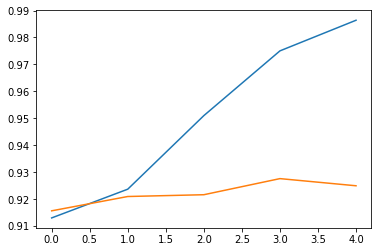

In [134]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')

In [135]:
scores = model.evaluate(X_val_prepared, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.49%


In [136]:
y_pred = model.predict(X_val_prepared)

In [137]:
y_pred

array([[2.2165447e-02],
       [7.9256296e-03],
       [1.2362343e-01],
       ...,
       [6.3626721e-06],
       [5.6996942e-04],
       [3.4302175e-03]], dtype=float32)

In [150]:
print(classification_report(y_val, y_pred > 0.3))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1377
           1       0.61      0.32      0.42       127

    accuracy                           0.93      1504
   macro avg       0.78      0.65      0.69      1504
weighted avg       0.91      0.93      0.91      1504



TODO: Balance dataset: https://www.youtube.com/watch?v=HtBDg619ozg

TODO: Choose threshold with https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

### Custom model 2

In [ ]:
# batch_size = 32
# nb_epoch = 12

# embedding_layer = Embedding(embedding_matrix.shape[0],
#                             embedding_matrix.shape[1],
#                             weights=[embedding_matrix],
#                             trainable=False)

# model = Sequential()
# model.add(embedding_layer)
# model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))
# model.summary()

In [ ]:
rnn = model.fit(X_train, Y_train, nb_epoch= nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))

### Hyperparameter tuning